In [16]:
import os

from timeit import default_timer as timer

import numpy as np

import pandas as pd

from matplotlib import pyplot as pp
%matplotlib inline

import seaborn as sb
sb.set(font_scale = 1.2, rc={'text.usetex' : False}, context = 'notebook')

from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     GridSearchCV,
                                     KFold)

from encode import (AttributeSelector,
                    PandasBinarizer,
                    PipelineFriendlyLabelEncoder)

The problem is to predict spend (or "purchase") based on some customer deographics.

**First look**

In [17]:
data = pd.read_csv('./data/blackfriday-train.csv',
                  dtype = {'Occupation': np.str,          
                           'Product_Category_1': np.str,  # These are categorical variables
                           'Product_Category_2': np.str,  # we want them to be treated as such 
                           'Product_Category_3': np.str}) # so convert them to strings

In [18]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6,14,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


So the data set appears to house as list of customers, customer demographics, products they've bought and the response variable: how much they've spent.

There are a few ways to approach the question. e.g. we could ask

(1) given a particular customer and thier demographics, what is that customer likely to spend on a particular product. This question would be useful for targetting current customers with the most appropriate products. This would involve using all availiable predictors.

(2) what is any hypothetical customer likely to spend on a given product given their demographics. This question would be useful for targetting both potential and current customers with the most appropriate products. This would involve dropping the user_ID column.

(3) what is any hypothetical customer likely to spend in my shop given their demographics. This approach asks the more general question "who will spend what in my store?". This would invlove dropping User_ID and Product_ID predictors.

I'm sure there are other obvious questions one could think of but these are the most obvious to me and each one is as interesting as the last. I am going randomly pick (3) as the question I want to work on.

In [19]:
pd.DataFrame({'Columns': data.columns})

,Columns
0,User_ID
1,Product_ID
2,Gender
3,Age
4,Occupation
5,City_Category
6,Stay_In_Current_City_Years
7,Marital_Status
8,Product_Category_1
9,Product_Category_2


In order to train and evaluate a model, I'll split the datatset into traning and validation sets.

In [20]:
# using 75% of the data in training 

trn, val = train_test_split(data, test_size = 0.25, random_state = 22)

From here on out the validation set is quarantined to prevent leakage.

**Identiying missing or erroneous data**

In [21]:
trn.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
463700,1005430,P00102642,F,46-50,1,B,1,1,4,8,9,3531
11842,1001776,P00179242,M,26-35,0,B,4+,1,11,NaN,NaN,4442
444098,1002304,P00111542,M,46-50,12,B,2,1,2,17,NaN,16195
540112,1005150,P00345742,M,26-35,3,C,3,1,1,2,15,15492
155892,1000056,P00150142,M,36-45,20,C,0,1,8,NaN,NaN,9993


In [22]:
# Identify NaNs in the dataset

isna = np.array( [ trn[col].isna().sum() for col in trn.columns ] )
pd.DataFrame({'Columns': trn.columns, 'NaNs': isna, 
              'pNaNs': isna/trn.shape[0],
              'dtype': trn.dtypes})

,Columns,NaNs,pNaNs,dtype
User_ID,User_ID,0,0.000000,int64
Product_ID,Product_ID,0,0.000000,object
Gender,Gender,0,0.000000,object
Age,Age,0,0.000000,object
Occupation,Occupation,0,0.000000,object
City_Category,City_Category,0,0.000000,object
Stay_In_Current_City_Years,Stay_In_Current_City_Years,0,0.000000,object
Marital_Status,Marital_Status,0,0.000000,int64
Product_Category_1,Product_Category_1,0,0.000000,object
Product_Category_2,Product_Category_2,130064,0.315268,object


The proportion of NaN elements in "Product_Category_2" and "Product_Category_3" columns is large. One possible interpretation is that a large fraction of products cannot be logically grouped into secondary or tiertiary catagories. There is good information contained in NaNs if this is the case.

Check for erroneous outlying datapoints and spurious catagories in feature distributions and count plots.

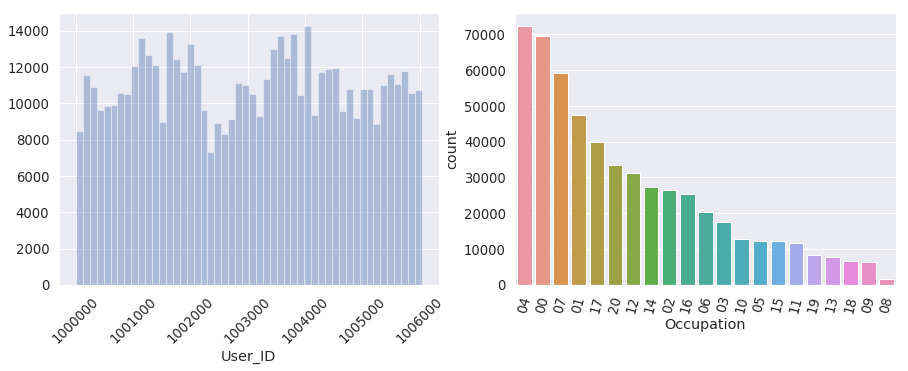

In [23]:
fig, (ax1, ax2) = pp.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

p = sb.distplot(data['User_ID'], ax = ax1, kde = False, norm_hist = False)
_ = ax1.tick_params(axis = 'x', rotation = 45)

# plot the bin counts in order of occupation
_ = sb.countplot(data['Occupation'], ax = ax2, order = data['Occupation'].value_counts().index)
lab2 = [item.get_text().zfill(2) for item in ax2.get_xticklabels()]
_ = ax2.set_xticklabels(lab2)
_ = ax2.tick_params(axis = 'x', rotation = 75)

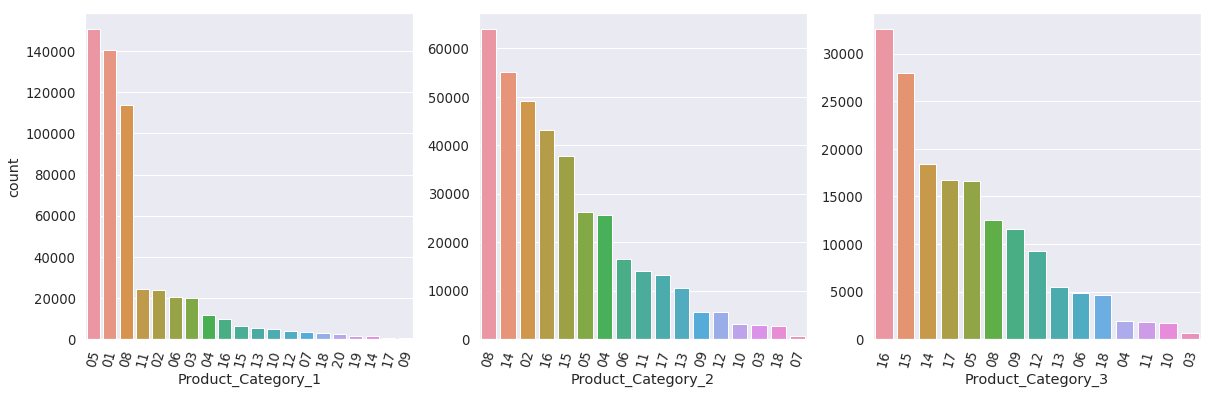

In [24]:
fig, (ax1, ax2, ax3) = pp.subplots(nrows = 1, ncols = 3, figsize = (20, 6))

_ = sb.countplot(data['Product_Category_1'], ax = ax1, 
                 order = data['Product_Category_1'].value_counts().index)

cat2 = data['Product_Category_2'].dropna().astype(np.int16)
cat3 = data['Product_Category_3'].dropna().astype(np.int16)

_ = sb.countplot(cat2, ax = ax2, 
                 order = cat2.value_counts().index)

_ = sb.countplot(cat3, ax = ax3,
                 order = cat3.value_counts().index)

_ = ax2.set_ylabel('')
_ = ax3.set_ylabel('')

lab1 = [item.get_text().zfill(2) for item in ax1.get_xticklabels()]
lab2 = [item.get_text().zfill(2) for item in ax2.get_xticklabels()]
lab3 = [item.get_text().zfill(2) for item in ax3.get_xticklabels()]

_ = ax1.set_xticklabels(lab1)
_ = ax2.set_xticklabels(lab2)
_ = ax3.set_xticklabels(lab3)

_ = ax1.tick_params(axis = 'x', rotation = 75)
_ = ax2.tick_params(axis = 'x', rotation = 75)
_ = ax3.tick_params(axis = 'x', rotation = 75)

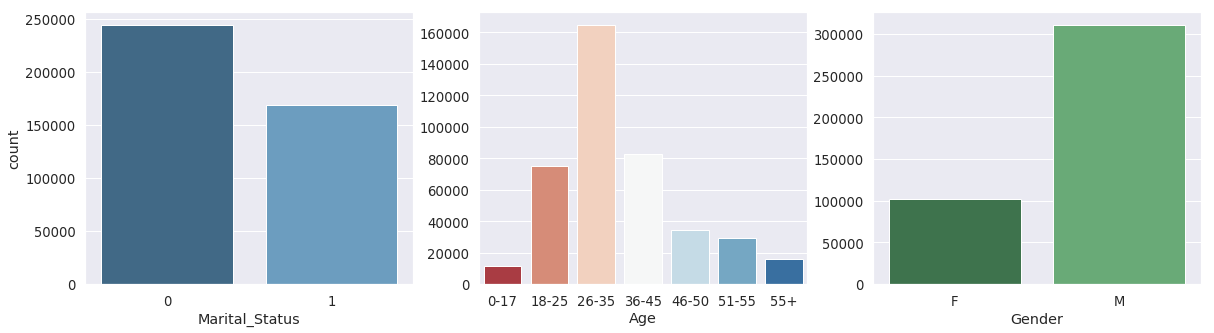

In [25]:
fig, (ax1, ax2, ax3) = pp.subplots(nrows = 1, ncols = 3, figsize = (20, 5))

_ = sb.countplot(trn['Marital_Status'], ax = ax1, palette = 'Blues_d')
_ = sb.countplot(trn['Age'], ax = ax2, palette = 'RdBu', order = np.sort( np.unique(trn['Age']) ) )
_ = sb.countplot(trn['Gender'], ax = ax3, palette = 'Greens_d')


_ = ax2.set_ylabel('')
_ = ax3.set_ylabel('')

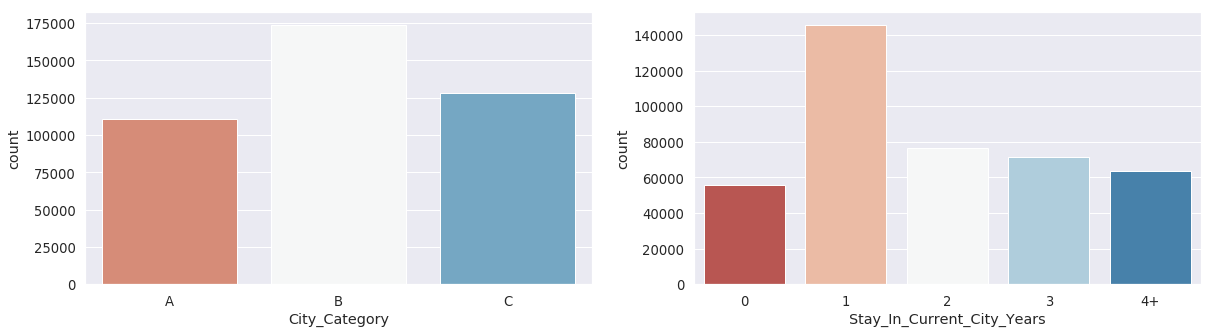

In [26]:
fig, (ax1, ax2) = pp.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

_ = sb.countplot(trn['City_Category'], ax = ax1, palette = 'RdBu', order = ['A', 'B', 'C'])
_ = sb.countplot(trn['Stay_In_Current_City_Years'], ax = ax2, palette = 'RdBu', order = ['0', '1', '2', '3', '4+'])

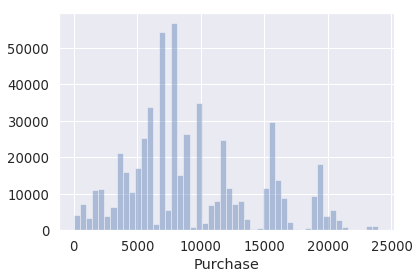

In [27]:
p = sb.distplot(data['Purchase'], kde = False, norm_hist = False)

Other than for Product_Category_2 and Product_Category_3, which we will return to, there are no outliers, erroneous catagories or missing data.

**Visualizing the dataset**

From the above plots one can deduce that there are some slight imbalances in the dataset.

- Occupation bin counts decline of by a factor of approximately 45 from the highlest sampled bin to the lowest.


- Three product categories dominate the Product_Category_1 bin count.


- Product_Cataegory_2 and Product_Cataegory_3 bin counts decline by a factor of approximately 60 and 15 from the highest to lowest sampled bins respectively. This observation does not take into account NaNs.


- Three times as many males are sampled as females.


- Age is highly peaked in the 26 - 35 category.


- There are significantly more people sampled in the 1 year category of Stay_In_Current_City_Years, than the other categories.

These are not huge imbalances but I point them out since upsampling might be something to try if one wants to eek out more signal later after a first attempt.

**Feature encoding**

Some necessary feature encoding i.e. coverting ordered catagorical variables into ordered numerical variables, one-hot-encoding others. Note that I'm one-hot-encoding NaNs in Product_Category_2, 3, since as discussed above these contain information. All the encoding is done by pipelines I've set up in external scripts supplied with this nb.

In [28]:
# list of features to convert to numerical encoding
tonum = ['Age', 'Gender', 'Stay_In_Current_City_Years']

In [29]:
# list of features to convert to one-hot encoding
toonehot = ['Occupation', 'City_Category', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']

In [30]:
# set up pipeline for numerical encoding
pipe_1 = [ (name, Pipeline([ 
    ( 'selector', AttributeSelector(key = name) ),
    ( 'encoder', PipelineFriendlyLabelEncoder() ) ]) ) for name in tonum ]

In [31]:
# set up pipeline for one-hot encoding
pipe_2 =  [ (name, Pipeline([
    ( 'selector', AttributeSelector(key = name) ),
    ( 'encoder', PandasBinarizer(dummy_na = False) )]) ) for name in toonehot[0:3] ]

pipe_2 =  pipe_2 + [ (name, Pipeline([
    ( 'selector', AttributeSelector(key = name) ),
    ( 'encoder', PandasBinarizer(dummy_na = True) )]) ) for name in toonehot[3:] ]

In [32]:
pipelines = pipe_1 + pipe_2 

In [33]:
# unionize transformers
union = FeatureUnion(pipelines)
feats = union.fit_transform(trn)

In [34]:
# just some cleaning up of column names
newcols = ['Age', 'Gender', 'Stay_In_Current_City_Years']
for i, name in enumerate(toonehot):
    n = i + len(tonum)
    dummies = union.transformer_list[n][1].named_steps['encoder'].columns
    for dum in dummies:
        newcols.append(name + '_' + str(dum).replace('.0', ''))

This is the encoded dataset I'm working with from here on out

In [35]:
# create a new working dataset
wrk = pd.DataFrame(data = feats, columns = newcols, index = trn.index)

In [36]:
wrk = trn[['Product_ID', 'User_ID', 'Purchase']].join(wrk)

**Baseline Model**

I'm going use a gradient boosting predictor. I'll compare subsequent models with this baseline model to compare performance.

In [23]:
# Gradient boosting

X = wrk.drop(['Purchase','Product_ID', 'User_ID'], axis = 1)
y = wrk['Purchase']

fn = 'baseline.pkl'

if os.path.exists(fn):
    baseline = joblib.load(fn)
else:
    
    start = timer()
    
    # 5-fold cross validation
    folds = KFold(n_splits = 5, random_state=42, shuffle = True)
    baseline = []

    gboost = GradientBoostingRegressor()

    for itrn, itst in folds.split(X):
        baseline.append( gboost.fit(X.iloc[itrn], y.iloc[itrn]) )
    
    # dump the models for future reference
    joblib.dump(models, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 6.13 minutes


Here's the CV score

In [24]:
np.array([ np.sqrt( mean_squared_error( model.predict(X), y ) ) for model in baseline ]).mean()

3011.9709642352427

**Feature Engineering**

We'll now try some simple feature engineering to see if we can improve on that

In [37]:
# this function takes a dataset grouped on a arbitrary predictor
# and returns the most common value of another arbitrary predictor
# within that group.

# e.g. you might group by product_ID and then want to know the 
# most common age of customers buying that product, voila!
def most_common_feature_per_group(group, feature):
    
    top = group[feature].apply(lambda x: x.mode())
    # convert series to data frame and rename columns
    top = top.to_frame().rename({feature: 'Most_Common_' + feature}, axis = 1)
    
    keys = group.keys
    try:
        keys + []
    except TypeError:
        keys = [keys]
    
    top = pd.get_dummies(top, columns = ['Most_Common_' + feature]).groupby(keys[0]).sum()
    return top

In [38]:
group = trn.groupby('Product_ID')

In [39]:
# most common buyer age per product.
top_age = most_common_feature_per_group(group, 'Age')

# most common length of stay in city per product
top_stay = most_common_feature_per_group(group, 'Stay_In_Current_City_Years')

# can do the same to features with non-natural ordering such as occupation
top_occ = most_common_feature_per_group(group, 'Occupation')

# same again with the city category
top_city = most_common_feature_per_group(group, 'City_Category')

In [40]:
# total purchases of each product
group = trn.groupby('Product_ID')
n_buys = group.count()['User_ID'].to_frame().rename({'User_ID': 'N_Buys'}, axis = 1)

In [41]:
group = trn.groupby(['Product_ID', 'Gender'], observed = True)

In [42]:
# given a doubly grouped data set, this will count
# the number of occurances of a particular feature
# within that double group

# e.g. total number of purchases per product_ID per gender

def count_feature_per_feature_per_group(group):
    keys = group.keys
    cnt = group.count()
    cnt = cnt.iloc[:, 0].to_frame().rename({cnt.columns[0]: keys[1] + '_Count'}, axis = 1)
    levels = cnt.index.levels[1]
    cnt = cnt.unstack()[keys[1] + '_Count']
    for level in levels:
        cnt.rename({level: keys[1] +'_'+ str(level) + '_Count'}, axis = 1, inplace = True)
    cnt.fillna(0., inplace = True)
    return cnt

In [43]:
# as above except this returns a proportion
# instead of a count

def prop_feature_per_feature_per_group(count):
    
    res = count.copy()
    for col in res.columns:
        res[col] = res[col] / res[col].sum()
        res = res.rename( {col : col.replace('Count', 'Prop')}, axis = 1)#, inplace = True )
        
    return res

In [44]:
# total purchases per product per gender
cnt_mf = count_feature_per_feature_per_group(group)
cnt_mf.head()
# gender is imbalanced towards male customers
# so total purchases as a proportion of gender might 
# also provide useful info

n_M = np.count_nonzero(trn['Gender'] == 'M')
n_F = np.count_nonzero(trn['Gender'] == 'F')

prp_m = cnt_mf['Gender_M_Count'].to_frame().rename({'Gender_M_Count':'Gender_M_Prop'}, axis = 1)/n_M
prp_f = cnt_mf['Gender_F_Count'].to_frame().rename({'Gender_F_Count':'Gender_F_Prop'}, axis = 1)/n_F

In [45]:
# total purchases per product per age
group = wrk.groupby(['Product_ID', 'Age'])

cnt_age = count_feature_per_feature_per_group(group)

# total purchases as a proportion of age
prp_age = prop_feature_per_feature_per_group(cnt_age)

In [46]:
# Total purchases per product per occupation
group = trn.groupby(['Product_ID', 'Occupation'])

cnt_occ = count_feature_per_feature_per_group(group)

# total purchases as a proportion of occupation
prp_occ = prop_feature_per_feature_per_group(cnt_occ)

In [47]:
# Total purchases per product per city category
group = trn.groupby(['Product_ID', 'City_Category'])

cnt_city = count_feature_per_feature_per_group(group)

# total purchases as a proportion of city category
prp_city = prop_feature_per_feature_per_group(cnt_city)

In [48]:
# Total purchases per product per stay in current city
group = wrk.groupby(['Product_ID', 'Stay_In_Current_City_Years'])

cnt_stay = count_feature_per_feature_per_group(group)

# Total purchases as a proportion of stay in current city
prp_stay = prop_feature_per_feature_per_group(cnt_stay)

In [49]:
# Total purchases per product per marital status
group = trn.groupby(['Product_ID', 'Marital_Status'])

cnt_mari = count_feature_per_feature_per_group(group)

# Total purchases per product as a proportion of marital status
prp_mari = prop_feature_per_feature_per_group(cnt_mari)

In [50]:
# collect engineered features
feat = [top_age, top_stay, 
        top_occ, top_city, 
        cnt_mf, prp_m, prp_f, 
        cnt_age, prp_age, 
        cnt_occ, prp_occ, 
        cnt_city, prp_city,
        cnt_stay, prp_stay,
        cnt_mari, prp_mari]

engin = wrk[wrk.columns]
for f in feat:
    engin = engin.merge(f, how = 'left', on = 'Product_ID')

**Train model on engineered data**

In [53]:
# dropping predictors relevent to question (3).
# see discussion at the beginning of this notebook

X = engin.drop(['Purchase','Product_ID', 'User_ID'], axis = 1)
y = engin['Purchase']

In [54]:
# Gradient boosting 

fn = 'engineered.pkl'

if os.path.exists(fn):
    engineered = joblib.load(fn)
else:
    
    start = timer()
    
    folds = KFold(n_splits = 5, random_state = 12)
    engineered = []
    gboost = GradientBoostingRegressor()
    
    for itrn, itst in folds.split(X):
        
        engineered.append( gboost.fit(X.iloc[itrn], y.iloc[itrn]) )
    
    joblib.dump(engineered, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

In [55]:
np.array([ np.sqrt( mean_squared_error( model.predict(X), y ) ) for model in engineered ]).mean()

2826.123817471148

So some simple feature engineering has resulted in a large gain in model precision but training this model took way too long on my measly laptop. By looking at feature importance, it might be possible to reduce the size of this data set by pruning some unimportant features.

**Feature Selection**

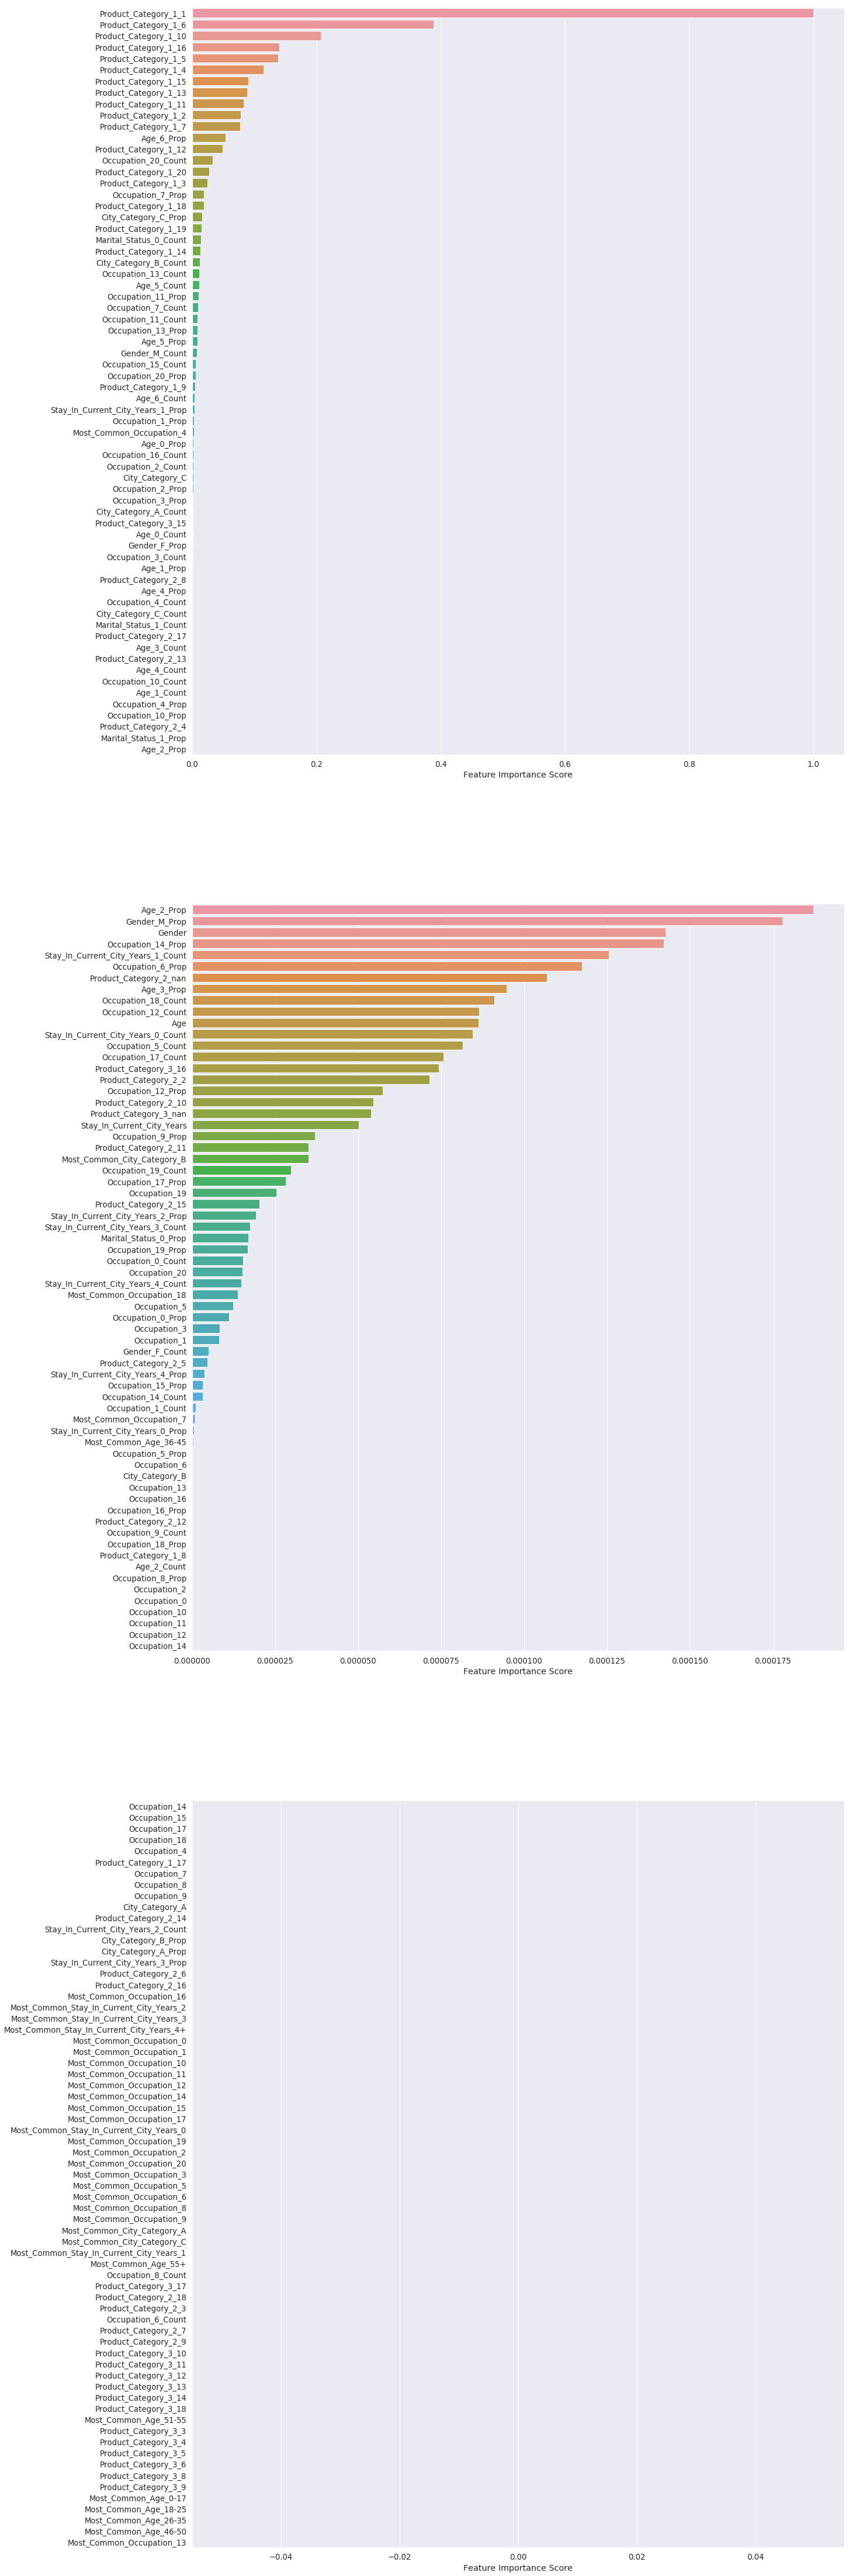

In [56]:
# plotting average feature importance in each of the cross validated models
av_importance = np.array([ x.feature_importances_ / x.feature_importances_.max() for x in engineered]).T
av_importance = pd.Series( av_importance.mean( axis = 1 ), X.columns ).sort_values( ascending = False )

fig, axes = pp.subplots(nrows = 3, ncols = 1, figsize = (20, 80))

sb.barplot(x = av_importance[0:66], y = av_importance.index[0:66], ax = axes[0], orient = 'h')

sb.barplot(x = av_importance[65:131], y = av_importance.index[65:131], ax = axes[1], orient = 'h')

sb.barplot(x = av_importance[130:], y = av_importance.index[130:], ax = axes[2], orient = 'h')

axes[0].set_xlabel('Feature Importance Score');
axes[1].set_xlabel('Feature Importance Score');
axes[2].set_xlabel('Feature Importance Score');

Remove features with close to zero average importance and re-run the model

Two questions:

(1) Are we reducing the predictive power?
(2) Are we significantly decreasing runtime?

In [44]:
# dropping features with low average importance
todrop = av_importance.index[av_importance <= 5e-4]
len(todrop), len(av_importance)

(146, 197)

In [45]:
# rerun the model
fn = 'selected.pkl'

if os.path.exists(fn):
    selected = joblib.load(fn)
else:
    
    start = timer()
    
    gboost = GradientBoostingRegressor()
    folds = KFold(n_splits = 5, random_state = 5, shuffle = True)
    selected = []
    
    for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
        
        selected.append( gboost.fit(X.drop(todrop, axis = 1).iloc[itrn], y.iloc[itrn]) )
    
    joblib.dump(selected, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 9.84 minutes


In [46]:
np.array([ np.sqrt( mean_squared_error( model.predict(X.drop(todrop, axis = 1)), y ) ) for model in selected ]).mean()

2827.8243050771844

A significant reduction in runtime for small loss in predictive power. However note that one would normally try to tune a model first since this can significantly increase the power of a given precitor. Unfortuneately I just dont have the computing power to try this so I'll have to drop predictors here before tuning.

**Tune the model**

To tune the model I'm starting with a high learning rate and a large number of trees with an early stopping criteria. The optimum number of trees should range from between 40-70 to allow us to go on and tune of the tree parameters in reasonable time. We'll then come back to learning rate and number of trees to further optimize them.

In [47]:
# start with some initial tuning parameters incl.
# a relatively high leraning rate and large number 
# of trees.

fn = 'tuned_1.0.pkl'

folds = KFold( n_splits = 5, random_state = 1036, shuffle = True )

if os.path.exists(fn):
    
    gboost = joblib.load(fn)

else:

    start = timer()
    
    tuned_1 = []
    
    gboost = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.6,
                                       min_samples_split = 500, min_samples_leaf = 50, 
                                       max_depth = 8, max_features = 'sqrt', 
                                       subsample = 0.8, random_state = 10,
                                       validation_fraction = 0.2,
                                       n_iter_no_change = 5, tol = 0.01)
    
    for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
        
        model = gboost.fit( X.drop(todrop, axis = 1).iloc[itrn], y.iloc[itrn] )
        tuned_1.append( model )
    
    joblib.dump(tuned_1, fn)
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )
    

That took 5.29 minutes


In [49]:
scores = []; i = 0

for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
    
    model = tuned_1[i]
    
    yhat = model.predict( X.drop(todrop, axis = 1).iloc[itst] )
    
    scores.append( mean_squared_error( yhat, y[itst] ) )
    
    i += 1

In [50]:
np.sqrt( np.mean(scores) )

2648.898299798905

In [60]:
n_estimators = np.mean( [ model.estimators_.size for model in tuned_1 ] )
n_estimators

78.0

Yet more significant gains in the model's predictive power. Now let's tune max_depth min_samples_split over a grid. This will take a while

In [61]:
fn = 'tuned_2.pkl'

if os.path.exists(fn):
    
    tuned_2 = joblib.load(fn)

else:

    params = { 'max_depth': [4,6,8,10,12,14],  'min_samples_split': [300,500,700,900,1100,1300]}

    gboost = GradientBoostingRegressor(n_estimators = int(n_estimators), learning_rate = 0.6,
                                       min_samples_leaf = 50, max_features = 'sqrt', 
                                       subsample = 0.8, random_state = 19)
    start = timer()

    tuned_2 = GridSearchCV( gboost, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 3,
                           return_train_score=True)
    tuned_2.fit( X.drop(todrop, axis = 1), y )
    
    joblib.dump(tuned_2, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 115.23 minutes


In [63]:
results = pd.DataFrame(data  = tuned_2.cv_results_)

In [67]:
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
13,188.555858,0.788134,1.018427,0.133867,8,500,"{'max_depth': 8, 'min_samples_split': 500}",-7.141358e+06,-7.088770e+06,-7.134529e+06,-7.121552e+06,23347.787248,1,-6.957817e+06,-6.970450e+06,-6.951203e+06,-6.959823e+06,7984.799379
12,236.788671,9.279577,0.981871,0.097167,8,300,"{'max_depth': 8, 'min_samples_split': 300}",-7.133584e+06,-7.090437e+06,-7.141795e+06,-7.121939e+06,22525.765452,2,-6.939834e+06,-6.964477e+06,-6.930176e+06,-6.944829e+06,14441.920551
23,206.236491,1.549776,1.035014,0.030991,10,1300,"{'max_depth': 10, 'min_samples_split': 1300}",-7.137307e+06,-7.094856e+06,-7.135850e+06,-7.122671e+06,19677.321071,3,-6.940496e+06,-6.967476e+06,-6.945718e+06,-6.951230e+06,11683.803668
15,154.751090,0.899561,0.910539,0.038179,8,900,"{'max_depth': 8, 'min_samples_split': 900}",-7.136060e+06,-7.094209e+06,-7.137754e+06,-7.122674e+06,20140.202079,4,-6.963202e+06,-6.986990e+06,-6.965668e+06,-6.971954e+06,10680.286334
22,212.242952,8.734834,1.105481,0.134696,10,1100,"{'max_depth': 10, 'min_samples_split': 1100}",-7.131760e+06,-7.092080e+06,-7.146520e+06,-7.123453e+06,22988.463149,5,-6.939466e+06,-6.962737e+06,-6.938982e+06,-6.947062e+06,11086.214242
16,147.762393,0.923849,0.925556,0.030440,8,1100,"{'max_depth': 8, 'min_samples_split': 1100}",-7.143099e+06,-7.090804e+06,-7.138378e+06,-7.124094e+06,23618.246031,6,-6.976149e+06,-6.988008e+06,-6.971232e+06,-6.978463e+06,7041.511501
28,278.700197,9.060104,1.224321,0.046587,12,1100,"{'max_depth': 12, 'min_samples_split': 1100}",-7.136252e+06,-7.097044e+06,-7.140334e+06,-7.124543e+06,19516.002225,7,-6.924591e+06,-6.943549e+06,-6.922029e+06,-6.930057e+06,9597.832542
19,306.360312,14.234602,1.143202,0.009687,10,500,"{'max_depth': 10, 'min_samples_split': 500}",-7.143673e+06,-7.090199e+06,-7.141531e+06,-7.125134e+06,24718.481867,8,-6.924406e+06,-6.942556e+06,-6.917199e+06,-6.928054e+06,10668.244060
17,143.716231,3.162427,0.898864,0.045312,8,1300,"{'max_depth': 8, 'min_samples_split': 1300}",-7.142728e+06,-7.096638e+06,-7.136690e+06,-7.125352e+06,20453.128758,9,-6.982135e+06,-6.999589e+06,-6.976850e+06,-6.986191e+06,9716.263914
35,236.823886,72.793731,0.947954,0.253613,14,1300,"{'max_depth': 14, 'min_samples_split': 1300}",-7.139777e+06,-7.087915e+06,-7.148518e+06,-7.125404e+06,26747.384084,10,-6.916494e+06,-6.940379e+06,-6.912655e+06,-6.923176e+06,12264.670715


In [69]:
np.sqrt(-tuned_2.best_score_)

2668.6236746036593

In [85]:
# best parameters
inx = np.flatnonzero(results.rank_test_score == 1)
results[['param_max_depth', 'param_min_samples_split']].iloc[inx]

,param_max_depth,param_min_samples_split
13,8,500


So as luck would have it we were already using the best values of max_depth and min_samples_split. Notice that the best CV score in this case is worse than in the initial case. This is just a result of variance between the cross validated subsets.

In [93]:
max_depth = results.param_max_depth.iloc[inx].values[0]
min_samples_split = results.param_min_samples_split.iloc[inx].values[0]

Now we'll tune min_samples_leaf. We don't expect to gain much here this just makes overfitting more difficalt.

In [100]:
fn = 'tuned_3.pkl'

if os.path.exists(fn):
    
    tuned_3 = joblib.load(fn)

else:

    params = {'min_samples_leaf': [20, 30, 40, 50, 60, 70, 80]}
    
    gboost = GradientBoostingRegressor(n_estimators = int(n_estimators), learning_rate = 0.6,
                                       max_depth = max_depth, min_samples_split = min_samples_split, 
                                       max_features = 'sqrt', 
                                       subsample = 0.8, random_state = 1244)
    start = timer()

    tuned_3 = GridSearchCV( gboost, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 3,
                           return_train_score=True)
    tuned_3.fit( X.drop(todrop, axis = 1), y )
    
    joblib.dump(tuned_3, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 19.39 minutes


In [101]:
results = pd.DataFrame(data  = tuned_3.cv_results_)

In [102]:
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,208.136347,4.100733,0.904003,0.143928,30,{'min_samples_leaf': 30},-7.138469e+06,-7.089005e+06,-7.139882e+06,-7.122452e+06,23657.754893,1,-6.949634e+06,-6.975137e+06,-6.950909e+06,-6.958560e+06,11733.360051
4,186.332498,2.665941,0.915402,0.035526,60,{'min_samples_leaf': 60},-7.145397e+06,-7.093369e+06,-7.135872e+06,-7.124880e+06,22618.057159,2,-6.954237e+06,-6.979434e+06,-6.950719e+06,-6.961464e+06,12787.982554
5,188.462734,4.971134,0.915934,0.015988,70,{'min_samples_leaf': 70},-7.143306e+06,-7.092419e+06,-7.141548e+06,-7.125758e+06,23584.822841,3,-6.960726e+06,-6.971385e+06,-6.955009e+06,-6.962373e+06,6786.344184
6,145.038942,59.254326,0.650668,0.153540,80,{'min_samples_leaf': 80},-7.141018e+06,-7.097483e+06,-7.144242e+06,-7.127581e+06,21322.923372,4,-6.955587e+06,-6.979246e+06,-6.956560e+06,-6.963797e+06,10930.791914
0,207.020962,1.783868,0.985309,0.195131,20,{'min_samples_leaf': 20},-7.146592e+06,-7.097210e+06,-7.140902e+06,-7.128235e+06,22060.415285,5,-6.950183e+06,-6.973305e+06,-6.949706e+06,-6.957731e+06,11014.232768
3,191.157559,6.014314,0.871661,0.044723,50,{'min_samples_leaf': 50},-7.142594e+06,-7.099873e+06,-7.143284e+06,-7.128583e+06,20303.593099,6,-6.951531e+06,-6.977600e+06,-6.951008e+06,-6.960047e+06,12414.218555
2,202.856254,8.102032,0.913020,0.035465,40,{'min_samples_leaf': 40},-7.147164e+06,-7.100614e+06,-7.139583e+06,-7.129120e+06,20393.496739,7,-6.955930e+06,-6.971890e+06,-6.948972e+06,-6.958931e+06,9593.861824


In [103]:
np.sqrt(-tuned_3.best_score_)

2668.792194021847

In [110]:
inx = np.flatnonzero(results.rank_test_score == 1)
min_samples_leaf = results.param_min_samples_leaf.iloc[inx].values[0]

The final tree related hyperparameter to tune is max features. Currently we're using sq.root the number of features, which is

In [108]:
np.sqrt(X.drop(todrop, axis = 1).shape[1])

7.14142842854285

In [121]:
fn = 'tuned_4.pkl'

if os.path.exists(fn):
    
    tuned_4 = joblib.load(fn)

else:

    params = {'max_features': [3,5,7,9,11,12,14,16]}
    
    gboost = GradientBoostingRegressor(n_estimators = int(n_estimators), learning_rate = 0.6,
                                       max_depth = max_depth, min_samples_split = min_samples_split, 
                                       min_samples_leaf = min_samples_leaf, 
                                       subsample = 0.8, random_state = 193920)
    start = timer()

    tuned_4 = GridSearchCV( gboost, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 3,
                           return_train_score=True)
    tuned_4.fit( X.drop(todrop, axis = 1), y )
    
    joblib.dump(tuned_4, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

In [112]:
results = pd.DataFrame(data  = tuned_4.cv_results_)

In [113]:
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,229.335483,19.621914,0.929133,0.070948,7,{'max_features': 7},-7.128179e+06,-7.088561e+06,-7.138477e+06,-7.118406e+06,21518.078960,1,-6.941793e+06,-6.970854e+06,-6.947977e+06,-6.953541e+06,12499.393535
4,284.706140,8.834286,0.958793,0.017724,11,{'max_features': 11},-7.130617e+06,-7.090299e+06,-7.136875e+06,-7.119264e+06,20640.062012,2,-6.935584e+06,-6.964995e+06,-6.939988e+06,-6.946856e+06,12951.778843
3,250.124280,3.375369,1.064390,0.195474,9,{'max_features': 9},-7.135801e+06,-7.089357e+06,-7.134947e+06,-7.120035e+06,21695.280783,3,-6.944466e+06,-6.967495e+06,-6.945472e+06,-6.952478e+06,10626.896899
5,310.451536,5.237225,1.043256,0.125590,12,{'max_features': 12},-7.132610e+06,-7.090148e+06,-7.138072e+06,-7.120277e+06,21420.428040,4,-6.937403e+06,-6.960000e+06,-6.934325e+06,-6.943909e+06,11446.913205
7,304.785777,48.399702,0.483164,0.032304,16,{'max_features': 16},-7.132589e+06,-7.091423e+06,-7.137815e+06,-7.120609e+06,20747.564219,5,-6.935064e+06,-6.959512e+06,-6.938485e+06,-6.944354e+06,10808.856954
1,196.166534,7.958595,1.109179,0.047415,5,{'max_features': 5},-7.135401e+06,-7.097818e+06,-7.134070e+06,-7.122430e+06,17411.616513,6,-6.958991e+06,-6.986348e+06,-6.947660e+06,-6.964333e+06,16239.719521
6,353.160337,6.562778,0.963274,0.024787,14,{'max_features': 14},-7.137139e+06,-7.084817e+06,-7.145627e+06,-7.122528e+06,26889.669971,7,-6.937489e+06,-6.958911e+06,-6.940338e+06,-6.945580e+06,9498.468948
0,123.026383,1.951375,1.155081,0.088884,3,{'max_features': 3},-7.142286e+06,-7.123416e+06,-7.143652e+06,-7.136451e+06,9233.947354,8,-6.970232e+06,-7.011424e+06,-6.968709e+06,-6.983455e+06,19786.655993


Best score is given by max_features = 7, which is what we were already using.

In [117]:
inx = np.flatnonzero(results.rank_test_score == 1)
max_features = results.param_max_features.iloc[inx].values[0]

In [118]:
np.sqrt(-tuned_4.best_score_)

2668.0340223455287

We've now tuned all tree related parameters with the following results

In [120]:
print( 'min_samples_split = {:d}'.format(min_samples_split) )
print( 'max_depth = {:d}'.format(min_samples_leaf) )
print( 'min_samples_leaf = {:d}'.format(min_samples_leaf) )
print( 'max_features = {:d}'.format(max_features) )

min_samples_split = 500
max_depth = 30
min_samples_leaf = 30
min_features = 7


Time to tune subsample

In [122]:
fn = 'tuned_5.pkl'

if os.path.exists(fn):
    
    tuned_5 = joblib.load(fn)

else:

    params = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9,0.95]}
    
    gboost = GradientBoostingRegressor(n_estimators = int(n_estimators), learning_rate = 0.6,
                                       max_depth = max_depth, min_samples_split = min_samples_split, 
                                       min_samples_leaf = min_samples_leaf, 
                                       max_features = max_features, random_state = 19920)
    start = timer()

    tuned_5 = GridSearchCV( gboost, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 3,
                           return_train_score=True)
    tuned_5.fit( X.drop(todrop, axis = 1), y )
    
    joblib.dump(tuned_5, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 19.78 minutes


In [123]:
results = pd.DataFrame(data  = tuned_5.cv_results_)

In [124]:
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,156.267258,56.044763,0.617221,0.176076,0.95,{'subsample': 0.95},-7.129293e+06,-7.083044e+06,-7.127126e+06,-7.113155e+06,21309.657839,1,-6.929861e+06,-6.950934e+06,-6.925042e+06,-6.935279e+06,11243.144257
4,206.000079,1.911045,0.961934,0.059008,0.85,{'subsample': 0.85},-7.133041e+06,-7.083084e+06,-7.133908e+06,-7.116678e+06,23756.790328,2,-6.948745e+06,-6.967400e+06,-6.944838e+06,-6.953661e+06,9845.280771
5,203.937642,2.535653,0.923854,0.054089,0.9,{'subsample': 0.9},-7.132507e+06,-7.085887e+06,-7.134776e+06,-7.117723e+06,22530.975121,3,-6.932200e+06,-6.958572e+06,-6.941959e+06,-6.944244e+06,10886.873337
3,220.635027,2.195978,1.416068,0.138639,0.8,{'subsample': 0.8},-7.138925e+06,-7.092446e+06,-7.140457e+06,-7.123942e+06,22280.426415,4,-6.951917e+06,-6.969179e+06,-6.944625e+06,-6.955240e+06,10296.259874
2,193.408990,7.268881,0.964984,0.215602,0.75,{'subsample': 0.75},-7.140221e+06,-7.097092e+06,-7.148057e+06,-7.128457e+06,22407.736206,5,-6.958889e+06,-6.978179e+06,-6.956302e+06,-6.964457e+06,9760.620784
1,186.891116,1.883362,0.891347,0.061948,0.7,{'subsample': 0.7},-7.149962e+06,-7.109173e+06,-7.159204e+06,-7.139446e+06,21736.282515,6,-6.959281e+06,-6.993459e+06,-6.969628e+06,-6.974123e+06,14310.192024
0,174.597675,2.615584,0.953652,0.038767,0.6,{'subsample': 0.6},-7.158973e+06,-7.118018e+06,-7.157795e+06,-7.144929e+06,19034.662686,7,-6.986518e+06,-6.997452e+06,-6.979207e+06,-6.987726e+06,7497.462150


The best value of subsample is at the upper extreme of the range tested. We'll need to run another grid search to tune it. Here's the CV score for the last run

In [125]:
np.sqrt(-tuned_5.best_score_)

2667.049778644947

In [126]:
fn = 'tuned_6.pkl'

if os.path.exists(fn):
    
    tuned_6 = joblib.load(fn)

else:

    params = {'subsample':[0.93,0.94,0.95,0.96,0.97,0.98,0.99]}
    
    gboost = GradientBoostingRegressor(n_estimators = int(n_estimators), learning_rate = 0.6,
                                       max_depth = max_depth, min_samples_split = min_samples_split, 
                                       min_samples_leaf = min_samples_leaf, 
                                       max_features = max_features, random_state = 1874)
    start = timer()

    tuned_6 = GridSearchCV( gboost, params, scoring = 'neg_mean_squared_error', n_jobs = -1, cv = 3,
                           return_train_score=True)
    tuned_6.fit( X.drop(todrop, axis = 1), y )
    
    joblib.dump(tuned_6, fn)
    
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 21.81 minutes


In [127]:
results = pd.DataFrame(data  = tuned_6.cv_results_)

In [128]:
results.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
2,201.891232,1.152087,0.881974,0.050348,0.95,{'subsample': 0.95},-7.121469e+06,-7.080744e+06,-7.117839e+06,-7.106684e+06,18402.219376,1,-6.921862e+06,-6.944005e+06,-6.924251e+06,-6.930039e+06,9922.989267
4,231.117234,1.728745,1.018475,0.130776,0.97,{'subsample': 0.97},-7.123657e+06,-7.079817e+06,-7.126404e+06,-7.109960e+06,21343.221455,2,-6.925241e+06,-6.941937e+06,-6.921428e+06,-6.929535e+06,8906.090669
6,185.519424,82.777013,0.613930,0.161897,0.99,{'subsample': 0.99},-7.128986e+06,-7.074446e+06,-7.127605e+06,-7.110346e+06,25391.346457,3,-6.917640e+06,-6.946741e+06,-6.921987e+06,-6.928789e+06,12817.139530
5,241.175655,6.314782,1.001390,0.096019,0.98,{'subsample': 0.98},-7.126564e+06,-7.079832e+06,-7.128746e+06,-7.111714e+06,22561.518552,4,-6.918404e+06,-6.942552e+06,-6.920243e+06,-6.927066e+06,10975.822434
3,202.681593,3.800969,0.936275,0.020972,0.96,{'subsample': 0.96},-7.128816e+06,-7.081203e+06,-7.126957e+06,-7.112325e+06,22019.916913,5,-6.925708e+06,-6.953442e+06,-6.924937e+06,-6.934696e+06,13259.392830
1,201.621190,4.805341,0.927833,0.044947,0.94,{'subsample': 0.94},-7.129258e+06,-7.085095e+06,-7.129471e+06,-7.114608e+06,20868.790993,6,-6.929358e+06,-6.954346e+06,-6.925432e+06,-6.936379e+06,12805.624149
0,206.821003,2.088260,0.920664,0.095434,0.93,{'subsample': 0.93},-7.142589e+06,-7.080399e+06,-7.130809e+06,-7.117932e+06,26972.167553,7,-6.934711e+06,-6.954341e+06,-6.928369e+06,-6.939140e+06,11055.794426


In [129]:
np.sqrt(-tuned_6.best_score_)

2665.8364284421727

In [130]:
inx = np.flatnonzero(results.rank_test_score == 1)
subsample = results.param_subsample.iloc[inx].values[0]

With all other hyperparams tuned we can now go back to look at the learning rate and number of trees. We can simply decrease the learning rate and increase the number of trees with a stopping criteria. Let's start with learning_rate = 0.05, here goes...

In [132]:
fn = 'tuned_7.pkl'

folds = KFold( n_splits = 5, random_state = 103610, shuffle = True )

if os.path.exists(fn):
    
    tuned_7 = joblib.load(fn)

else:

    start = timer()
    
    tuned_7 = []
    
    gboost = GradientBoostingRegressor(n_estimators = 10000, learning_rate = 0.05,
                                       min_samples_split = min_samples_split, 
                                       min_samples_leaf = min_samples_leaf, 
                                       max_depth = max_depth, max_features = max_features, 
                                       subsample = subsample, random_state = 101,
                                       validation_fraction = 0.2,
                                       n_iter_no_change = 5, tol = 0.01)
    
    for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
        
        model = gboost.fit( X.drop(todrop, axis = 1).iloc[itrn], y.iloc[itrn] )
        tuned_7.append( model )
    
    joblib.dump(tuned_7, fn)
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 39.55 minutes


In [133]:
scores = []; i = 0

for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
    
    model = tuned_7[i]
    
    yhat = model.predict( X.drop(todrop, axis = 1).iloc[itst] )
    
    scores.append( mean_squared_error( yhat, y[itst] ) )
    
    i += 1

In [134]:
np.sqrt( np.mean(scores) )

2644.6104222139143

A slight gain, let's reduce learning rate to learning_rate = 0.005

In [135]:
fn = 'tuned_8.pkl'

folds = KFold( n_splits = 5, random_state = 103, shuffle = True )

if os.path.exists(fn):
    
    tuned_8 = joblib.load(fn)

else:

    start = timer()
    
    tuned_8 = []
    
    gboost = GradientBoostingRegressor(n_estimators = 10000, learning_rate = 0.005,
                                       min_samples_split = min_samples_split, 
                                       min_samples_leaf = min_samples_leaf, 
                                       max_depth = max_depth, max_features = max_features, 
                                       subsample = subsample, random_state = 11,
                                       validation_fraction = 0.2,
                                       n_iter_no_change = 5, tol = 0.01)
    
    for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
        
        model = gboost.fit( X.drop(todrop, axis = 1).iloc[itrn], y.iloc[itrn] )
        tuned_8.append( model )
    
    joblib.dump(tuned_8, fn)
    end = timer()
    
    print( 'That took {:.2f} minutes'.format( (end - start) / 60. ) )

That took 330.32 minutes


In [136]:
scores = []; i = 0

for itrn, itst in folds.split( X.drop(todrop, axis = 1) ):
    
    model = tuned_8[i]
    
    yhat = model.predict( X.drop(todrop, axis = 1).iloc[itst] )
    
    scores.append( mean_squared_error( yhat, y[itst] ) )
    
    i += 1

In [137]:
np.sqrt( np.mean(scores) )

2647.786449579781

In [143]:
tuned_8[0].n_estimators_

4785

We could go on but we're not gaining anything fast here. I'll stop and apply the final models to the test set taking the average value of each prediction.

We now must perform all the same work on the test set that we did to the training set. 

In [338]:
# unionize transformers
feats = union.fit_transform(val)

In [339]:
tst = pd.DataFrame(data = feats, columns = newcols, index = val.index)

In [340]:
tst = val[['Product_ID', 'User_ID', 'Purchase']].join(tst)

In [341]:
tst.head()

,Product_ID,User_ID,Purchase,Age,Gender,Stay_In_Current_City_Years,Occupation_0,Occupation_1,Occupation_10,Occupation_11,...,Product_Category_3_16,Product_Category_3_17,Product_Category_3_18,Product_Category_3_3,Product_Category_3_4,Product_Category_3_5,Product_Category_3_6,Product_Category_3_8,Product_Category_3_9,Product_Category_3_nan
354110,P00177342,1000550,7922,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
413041,P00140742,1003591,15812,3,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59633,P0096442,1003224,2766,2,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462184,P00108842,1005153,3473,2,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
182242,P00100842,1004097,5214,2,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [344]:
group = val.groupby('Product_ID')

In [345]:
# most common buyer age per product.
top_age = most_common_feature_per_group(group, 'Age')

# most common length of stay in city per product
top_stay = most_common_feature_per_group(group, 'Stay_In_Current_City_Years')

# can do the same to features with non-natural ordering such as occupation
top_occ = most_common_feature_per_group(group, 'Occupation')

# same again with the city category
top_city = most_common_feature_per_group(group, 'City_Category')

In [346]:
# total purchases of each product
group = val.groupby('Product_ID')
n_buys = group.count()['User_ID'].to_frame().rename({'User_ID': 'N_Buys'}, axis = 1)

In [347]:
group = val.groupby(['Product_ID', 'Gender'], observed = True)

In [348]:
# total purchases per product per gender
cnt_mf = count_feature_per_feature_per_group(group)
cnt_mf.head()
# gender is imbalanced towards male customers
# so total purchases as a proportion of gender might 
# also provide useful info

n_M = np.count_nonzero(trn['Gender'] == 'M')
n_F = np.count_nonzero(trn['Gender'] == 'F')

prp_m = cnt_mf['Gender_M_Count'].to_frame().rename({'Gender_M_Count':'Gender_M_Prop'}, axis = 1)/n_M
prp_f = cnt_mf['Gender_F_Count'].to_frame().rename({'Gender_F_Count':'Gender_F_Prop'}, axis = 1)/n_F

In [349]:
# total purchases per product per age
group = tst.groupby(['Product_ID', 'Age'])

cnt_age = count_feature_per_feature_per_group(group)

# total purchases as a proportion of age
prp_age = prop_feature_per_feature_per_group(cnt_age)

In [350]:
# Total purchases per product per occupation
group = val.groupby(['Product_ID', 'Occupation'])

cnt_occ = count_feature_per_feature_per_group(group)

# total purchases as a proportion of occupation
prp_occ = prop_feature_per_feature_per_group(cnt_occ)

In [351]:
# Total purchases per product per city category
group = val.groupby(['Product_ID', 'City_Category'])

cnt_city = count_feature_per_feature_per_group(group)

# total purchases as a proportion of city category
prp_city = prop_feature_per_feature_per_group(cnt_city)

In [352]:
# Total purchases per product per stay in current city
group = tst.groupby(['Product_ID', 'Stay_In_Current_City_Years'])

cnt_stay = count_feature_per_feature_per_group(group)

# Total purchases as a proportion of stay in current city
prp_stay = prop_feature_per_feature_per_group(cnt_stay)

In [353]:
# Total purchases per product per marital status
group = val.groupby(['Product_ID', 'Marital_Status'])

cnt_mari = count_feature_per_feature_per_group(group)

# Total purchases per product as a proportion of marital status
prp_mari = prop_feature_per_feature_per_group(cnt_mari)

In [354]:
# collect engineered features
feat = [top_age, top_stay, 
        top_occ, top_city, 
        cnt_mf, prp_m, prp_f, 
        cnt_age, prp_age, 
        cnt_occ, prp_occ, 
        cnt_city, prp_city,
        cnt_stay, prp_stay,
        cnt_mari, prp_mari]

engin = tst[tst.columns]
for f in feat:
    engin = engin.merge(f, how = 'left', on = 'Product_ID')

In [356]:
X_tst = engin.drop(['Purchase','Product_ID', 'User_ID'], axis = 1)
y_tst = engin['Purchase']

**Results**

Applying the test data to the model

In [365]:
prediction = tuned_8[0].predict(X_tst.drop(todrop, axis = 1))

test score:

In [366]:
np.sqrt(mean_squared_error(y_tst, prediction ))

3060.073641476253

Finally from a deviance plot, we can see the reduction in training set and test set error at each tree. We can see why we were not gaining much by reducing the learning rate between 0.05 and 0.005. After around 1500 trees, improvements become very slow. How much time do you have on your hands?  

In [378]:
n_trees = tuned_8[0].n_estimators_

test_score = np.zeros((n_trees,), dtype = np.float64)

for i, y_pred in enumerate(tuned_8[0].staged_predict(X_tst.drop(todrop, axis = 1))):
    test_score[i] = tuned_8[0].loss_(y_tst, y_pred)

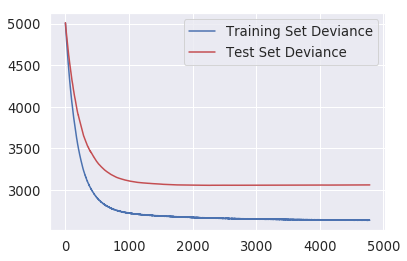

In [385]:
pp.plot(np.arange(tuned_8[0].n_estimators_) + 1, 
        np.sqrt(tuned_8[0].train_score_), 'b-', label='Training Set Deviance');
pp.plot(np.arange(tuned_8[0].n_estimators_) + 1, 
        np.sqrt(test_score), 'r-', label='Test Set Deviance');
pp.legend();